# Sepsis Challenge

Ines Krissaane

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import glob
from sklearn import linear_model
import datetime
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve, GridSearchCV
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import skimage.transform
import skimage.io
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
import time
import tensorflow

## Final Function

## Import Data 

In [4]:
X_tr = pd.read_csv('sepsis_data_all.csv')
X_tr.shape

(790215, 43)

In [5]:
X_tr = pd.read_csv('sepsis_data_setA.csv')
X_tr.head()

,Unnamed: 0,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,1
1,2,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,1
2,3,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,1
3,4,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,1
4,5,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,1


In [12]:
# Remove variables with more than 82% of na.
X_tr.drop(['EtCO2', 'BaseExcess','HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct' , 'Resp','Lactate','Magnesium','Phosphate',
    'Potassium', 'Bilirubin_total', 'TroponinI','Hct', 'Hgb','PTT',  'WBC', 'Unnamed: 0','Fibrinogen', 'Platelets',
    "Glucose"], axis = 1, inplace = True)

In [18]:
X_tr.drop(['Unit1', "Unit2"], axis = 1, inplace = True)

In [42]:
X_tr.drop(["ID"], axis = 1, inplace = True)

In [ ]:
#X_tr.drop(["X"], axis = 1, inplace = True)

Considering the formula MAP = (SBP + 2*DBP) / 3 and the correlation between MAP and DBP, SBP.
Let's remove SBP and DBP.

In [40]:
X_tr.drop(["DBP", "SBP"], axis = 1, inplace = True)

Missing values fill in by mean, makes sense because almost all the patients are normal. And you find many missing values only in the variable Temperature Temp. 

In [68]:
X_tr.fillna(method='bfill', inplace=True)
X_tr.fillna(method='ffill', inplace=True)

## Code to resume 

Function that is doing all of that.

In [6]:
def code(file) :
    data = pd.read_csv(file , sep='|')
    data.drop(['EtCO2', 'BaseExcess','HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct' , 'Resp','Lactate','Magnesium','Phosphate',
    'Potassium', 'Bilirubin_total', 'TroponinI','Hct', 'Hgb','PTT',  'WBC', 'Fibrinogen', 'Platelets',
    "Unit1", 'Unit2', "Glucose",'DBP','SBP'], axis = 1, inplace = True)
    data.fillna(method='bfill', inplace=True)
    data.fillna(method='ffill', inplace=True)
    Y_te = data.SepsisLabel
    data.drop(['SepsisLabel'], axis = 1, inplace = True)
    col = data.columns
    if sum(pd.isna(data['MAP'])) !=0 : 
        data['MAP'] =  [87] * len(data['MAP'] )
    if sum(pd.isna(data['Temp'])) !=0 : 
        data['Temp'] =  [36.7] * len(data['Temp'] )
    if sum(pd.isna(data['HR'])) !=0 : 
        data['HR'] =  [83.9] * len(data['HR'] )
    return(data, Y_te)       

## Anomaly Detection using Autoencoders

In [70]:
RANDOM_SEED = 101

X_train, X_test = train_test_split(X_tr, test_size=0.3, random_state = RANDOM_SEED)

X_train = X_train[X_train['SepsisLabel'] == 0]
X_train = X_train.drop(['SepsisLabel'], axis=1)

y_test  = X_test['SepsisLabel']
X_test  = X_test.drop(['SepsisLabel'], axis=1)
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (541063, 8)
Validation data size : (237065, 8)


In [71]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [46]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense,  Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Lambda, Flatten, Activation, Dropout
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend



In [47]:
from tensorflow.keras.models import Sequential

In [48]:
from tensorflow.keras import backend

In [73]:
input_dim = X_train.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="softmax")(input_layer)
encoder = Dense(int(encoding_dim * 2), activation="softmax")(encoder)
#encoder = Dense(int(2), activation="tanh")(encoder)
#decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='softmax')(encoder)
decoder = Dense(input_dim, activation='softmax')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________


In [74]:
nb_epoch = 100  
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=0
                        )

t_fin = datetime.datetime.now()

print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
df_history = pd.DataFrame(history.history)
1476.410182 Sec.  
for 8/6/3

In [75]:
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
df_history = pd.DataFrame(history.history)


Time to run the model: 726.867448 Sec.


In [110]:
df_history

,loss,val_loss
0,0.267438,0.264652
1,0.264517,0.264631
2,0.264511,0.264630
3,0.264511,0.264630
4,0.264510,0.264630
5,0.264510,0.264629
6,0.264511,0.264629
7,0.264511,0.264630
8,0.264510,0.264630
9,0.264510,0.264629


ValueError: x and y must have same first dimension, but have shapes (91,) and (90,)

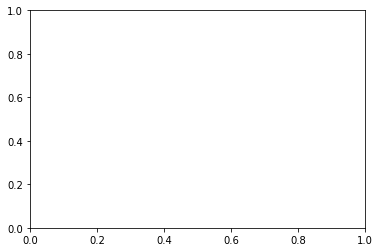

In [111]:
plt.plot(np.arange(10,101), df_history['loss'][10:101]);

In [77]:
predictions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()

,reconstruction_error,Label
count,237065.000000,237065.000000
mean,0.261574,0.021298
std,0.066999,0.144376
min,0.046114,0.000000
25%,0.201039,0.000000
50%,0.279479,0.000000
75%,0.317974,0.000000
max,0.476010,1.000000


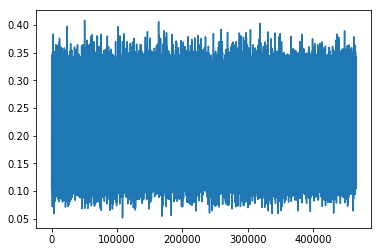

In [58]:
plt.plot(np.arange(0,len(df_error['reconstruction_error'])), df_error['reconstruction_error']);

In [59]:
sum(df_error['reconstruction_error'])

97768.70678038195

In [60]:
outliers = df_error.index[df_error.reconstruction_error > 0.2].tolist()

In [61]:
X_tr[X_tr.SepsisLabel == 1].shape

(27916, 9)

In [62]:
len(outliers)

264368

In [63]:
b =set(list(y_test[y_test == 1].index))
len([i for i, item in enumerate(outliers) if item in b])


5133

In [64]:
sum(y_test)

8351

## Save and load the model

In [79]:
from tensorflow.keras.models import model_from_json

In [80]:
model_json = autoencoder.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

autoencoder.save_weights("model2.h5")




In [81]:
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")

In [69]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### Normality of the reconstruction error

In [ ]:
from scipy import stats
k2, p = stats.normaltest(df_error['reconstruction_error'])
p

In [ ]:
import statsmodels.api as sm
import pylab
sm.qqplot(df_error['reconstruction_error'], loc = 4, scale = 3, line='s')

In [ ]:
arr = df_error['reconstruction_error']
arr.std()

In [ ]:
arr = df_error['reconstruction_error']
final_list = [ x for x in arr if (x > arr.mean() - 2 * arr.std())]
final_list = [x for x in final_list if (x < arr.mean() + 2 * arr.std())]
len(final_list)

## Test on files 

In [82]:
def code(file) :
    data = pd.read_csv(file , sep='|')
    data.drop(['EtCO2', 'BaseExcess','HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct' , 'Resp','Lactate','Magnesium','Phosphate',
    'Potassium', 'Bilirubin_total', 'TroponinI','Hct', 'Hgb','PTT',  'WBC', 'Fibrinogen', 'Platelets',
    "Unit1", 'Unit2', "Glucose",'DBP','SBP'], axis = 1, inplace = True)
    data.fillna(method='bfill', inplace=True)
    data.fillna(method='ffill', inplace=True)
    Y_te = data.SepsisLabel
    data.drop(['SepsisLabel'], axis = 1, inplace = True)
    col = data.columns
    if sum(pd.isna(data['MAP'])) !=0 : 
        data['MAP'] =  [87] * len(data['MAP'] )
    if sum(pd.isna(data['Temp'])) !=0 : 
        data['Temp'] =  [36.7] * len(data['Temp'] )
    if sum(pd.isna(data['HR'])) !=0 : 
        data['HR'] =  [83.9] * len(data['HR'] )
    return(data, Y_te)   

In [83]:
def load_challenge_data(file):
    with open(file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        data = np.loadtxt(f, delimiter='|')

    # Ignore SepsisLabel column if present.
    if column_names[-1] == 'SepsisLabel':
        column_names = column_names[:-1]
        data = data[:, :-1]

    return pd.DataFrame(data, columns = column_names )

In [84]:
load_challenge_data("training_setB/p119959.psv")

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,1.0
1,77.0,98.0,NaN,120.0,85.0,61.0,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,2.0
2,80.0,97.0,36.0,108.0,77.0,58.0,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,4.0
4,77.0,98.0,NaN,132.0,93.0,67.0,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,5.0
5,79.0,NaN,NaN,122.0,94.0,75.0,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,6.0
6,83.0,NaN,NaN,124.0,95.0,77.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,7.0
7,83.0,NaN,NaN,122.0,93.0,73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,8.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.5,NaN,309.0,56.0,0.0,1.0,0.0,-321.03,9.0
9,84.0,NaN,NaN,145.0,110.0,87.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.0,0.0,1.0,0.0,-321.03,10.0


In [85]:
d = code("training_setB/p119959.psv")[0]
r = code("training_setB/p119959.psv")[1]

In [86]:
d

,HR,O2Sat,Temp,MAP,Age,Gender,HospAdmTime,ICULOS
0,77.0,98.0,36.0,85.0,56,0,-321.03,1
1,77.0,98.0,36.0,85.0,56,0,-321.03,2
2,80.0,97.0,36.0,77.0,56,0,-321.03,3
3,77.0,98.0,35.6,93.0,56,0,-321.03,4
4,77.0,98.0,35.6,93.0,56,0,-321.03,5
5,79.0,100.0,35.6,94.0,56,0,-321.03,6
6,83.0,100.0,35.6,95.0,56,0,-321.03,7
7,83.0,100.0,35.6,93.0,56,0,-321.03,8
8,84.0,100.0,35.6,110.0,56,0,-321.03,9
9,84.0,100.0,35.6,110.0,56,0,-321.03,10


In [87]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d)
d

array([[0.        , 0.75      , 0.17391304, 0.21621622, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.75      , 0.17391304, 0.21621622, 0.        ,
        0.        , 0.        , 0.025     ],
       [0.07894737, 0.625     , 0.17391304, 0.        , 0.        ,
        0.        , 0.        , 0.05      ],
       [0.        , 0.75      , 0.        , 0.43243243, 0.        ,
        0.        , 0.        , 0.075     ],
       [0.        , 0.75      , 0.        , 0.43243243, 0.        ,
        0.        , 0.        , 0.1       ],
       [0.05263158, 1.        , 0.        , 0.45945946, 0.        ,
        0.        , 0.        , 0.125     ],
       [0.15789474, 1.        , 0.        , 0.48648649, 0.        ,
        0.        , 0.        , 0.15      ],
       [0.15789474, 1.        , 0.        , 0.43243243, 0.        ,
        0.        , 0.        , 0.175     ],
       [0.18421053, 1.        , 0.        , 0.89189189, 0.        ,
        0.        , 0.      

In [88]:
probabilities = loaded_model.predict(d)
mse = np.mean(np.power(d - probabilities , 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': r}, index=r.index)

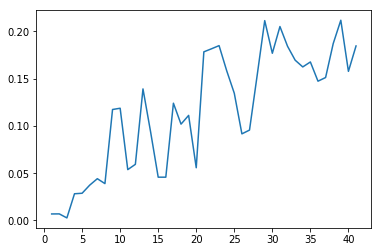

In [89]:
plt.plot(np.arange(1,len(df_error['reconstruction_error'])+1), df_error['reconstruction_error']);

In [90]:
df_error

,reconstruction_error,Label
0,0.006913,0
1,0.006990,0
2,0.002728,0
3,0.028245,0
4,0.028788,0
5,0.037352,0
6,0.044162,0
7,0.038973,0
8,0.117275,0
9,0.118600,0


In [91]:
outliers = df_error.index[df_error.reconstruction_error > 0.18].tolist()
outliers

[21, 22, 28, 30, 31, 37, 38, 40]

### All datasetB

In [92]:
def compute_auc(labels, predictions):
    # Check inputs for errors.

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.concatenate((np.array([1]), thresholds))

    if thresholds[-1] != 0:
        thresholds = np.concatenate((thresholds, np.array([0])))
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort predicted probabilities from largest to smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels == 1)
            tn[j] = np.sum(labels == 0)
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest prediction probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function of TPR /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant of TPR / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr[j + 1] - tpr[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the classifier using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the classifier using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_prediction_utility(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif labels[i] and not predictions[i]:
            fp += 1
        elif not labels[i] and predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   classifier using its binarized predictions.
#
# Example:
#   In [1]: labels = [0 0 0 0 1 1]
#   In [2]: predictions = [0 0 1 1 1 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 0.444444444444

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    if dt_early >= dt_optimal:
        raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

    if dt_optimal >= dt_late:
        raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if any(labels):
        is_septic = True
        t_sepsis = min(i for i, label in enumerate(labels) if label) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    # Define slopes and intercept points for affine utility functions of the
    # form u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

def get_parser():
    parser = argparse.ArgumentParser(description = 'Evaluate classifiers for cohort.')
    parser.add_argument('-l', '--labels_directory',      type=str, required=True,  help='Labels directory')
    parser.add_argument('-p', '--predictions_directory', type=str, required=True,  help='Predictions directory')
    parser.add_argument('-o', '--output_file',           type=str, required=False, help='Output filename')
    return parser

def run(args):
    auroc, auprc, accuracy, f_measure, utility = compute_scores_2019(args.labels_directory, args.predictions_directory)

    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(auroc, auprc, accuracy, f_measure, utility)

    if args.output_file:
        with open(args.output_file, 'w') as f:
            f.write(output_string)
    else:
        print(output_string)



In [106]:
utility = []
optimal = []
acc=[]
nopred=[]

for file in glob.glob("training_setB/*.psv"):  
    Y_te = code(file)[1]
    X_te = code(file)[0]
    
   
    scaler = MinMaxScaler()
    X_te = scaler.fit_transform(X_te)
    
    probabilities = loaded_model.predict(X_te)
    
    mse = np.mean(np.power(X_te - probabilities , 2), axis=1)
    df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': Y_te}, index=Y_te.index)
    outliers = df_error.index[df_error.reconstruction_error > 0.18].tolist()
    
    predictions = []
    for i in range(0, len(df_error) ):
        if df_error.reconstruction_error[i] > 0.23 :
            predictions.append(1)
        else :
            predictions.append(0)


    labels = df_error.Label
   
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
    acc.append(accuracy)
    utility.append(compute_prediction_utility(labels, predictions))
    optimal.append(compute_prediction_utility(labels, labels))
    
    fake = []
    for i in labels :
        fake.append(1-i)
    nopred.append(compute_prediction_utility(labels, fake))
    #nopred.append(compute_prediction_utility(labels, fake))

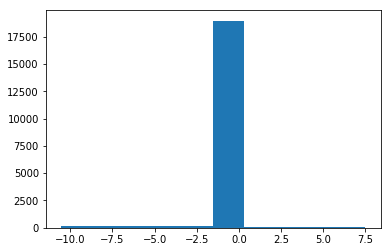

In [107]:
plt.hist(utility);

In [108]:
(sum(utility) - sum(nopred))/(sum(optimal) - sum(nopred))

0.7203645005333672

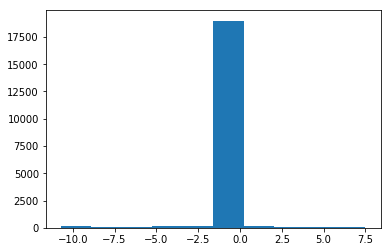

In [104]:
plt.hist(utility);

In [105]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

0.7217239136190832

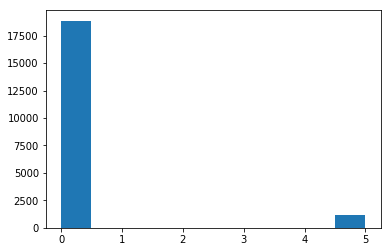

In [99]:
plt.hist(optimal);

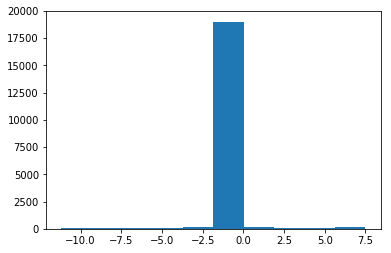

In [100]:
plt.hist(utility);

In [101]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

0.7175393272016654

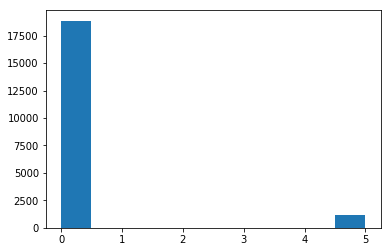

In [94]:
plt.hist(optimal);


In [97]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

0.7002084447926412

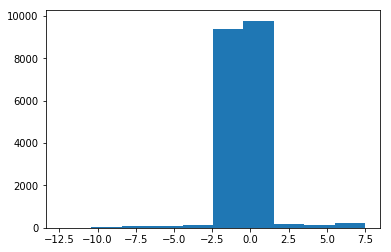

In [95]:
plt.hist(utility);

In [ ]:
data_n = pd.DataFrame(X_test_scaled, index= y_test.index)
                      
def compute_error_per_dim(point):
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = autoencoder.predict(initial_pt)
    
    return(abs(np.array(initial_pt  - reconstrcuted_pt)[0]))

In [ ]:
compute_error_per_dim(1342254)

In [ ]:
compute_error_per_dim(1126533)

In [ ]:
compute_error_per_dim(944174)

In [ ]:
compute_error_per_dim(1475332)

In [ ]:
compute_error_per_dim(993319)

In [ ]:
compute_error_per_dim(715894)

In [ ]:
compute_error_per_dim( 607628)

## Xgboost

In [ ]:
X_tr = pd.read_csv('sepsis_data_all.csv')

In [ ]:
X_tr.drop(['EtCO2', 'BaseExcess','HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct' , 'Resp','Lactate','Magnesium','Phosphate',
    'Potassium', 'Bilirubin_total', 'TroponinI','Hct', 'Hgb','PTT',  'WBC', 'Fibrinogen', 'Platelets',
    "Unit1", 'Unit2', "Glucose",'HospAdmTime','Unnamed: 0', 'ID','DBP','X','Temp','Age','Gender'], axis = 1, inplace = True)
X_tr.fillna(method='bfill', inplace=True)
X_tr.fillna(method='ffill', inplace=True)

Y_tr = X_tr.SepsisLabel
X_tr.drop(['SepsisLabel'], axis = 1, inplace = True)


In [ ]:
X_tr.tail()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tr,Y_tr,test_size=.3, random_state=42)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
num_boost_round = 999

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth': 11,
    'min_child_weight': 5,
    'eta':.01,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'binary:logistic',
    'eval_metric': 'rmse'
}

In [ ]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,12)
    for min_child_weight in range(1,7)
]

In [ ]:
min_mae = float("Inf")


best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

In [ ]:
params['max_depth'] = 11
params['min_child_weight'] = 5

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [ ]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.

In [ ]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['mae'],early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

In [ ]:
params['eta'] = .01

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

In [ ]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

In [ ]:
mean_absolute_error(best_model.predict(dtest), y_test)

In [ ]:
best_model.save_model("my_xgboost_model")

In [ ]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_xgboost_model")

In [ ]:
loaded_model.predict(dtest)

In [ ]:
model =  RandomForestRegressor(n_estimators=200)
model.fit(X_tr,Y_tr)

In [ ]:
print(best_model)

In [ ]:
sum(Y_tr == 0)/len(Y_tr)

In [ ]:
utility = []
optimal = []
nopred=[]
acc=[]
number_un = []
for file in glob.glob("training_setB/*.psv")[10000:20000]:  #[3200:5000]
    Y_te =  code(file)[1]
    X_te = code(file)[0]
    number_un.append(sum(Y_te))
   # print(file)
   # 1 probabilities  = model.predict(X_te)
    
    #2 
    dtest = xgb.DMatrix(X_te, label= Y_te)
    probabilities = best_model.predict(dtest)


    #probabilities = model.predict_proba(X_te)[:,1]
    #predictions = model.predict(X_te)
    for counter, value in enumerate(probabilities):
        if value > 0.1:
            if counter < (len(probabilities)-3) :
                probabilities[counter+1] = 1
                probabilities[counter+2] = 1
                probabilities[counter+3] = 1
    
    predictions = [] 
    for i in range (len(probabilities)):
        if probabilities[i] < 0.5 :   # 1 0.35
            predictions.append(0)
        else :
            predictions.append(1)

    labels = Y_te
    fake = []
    for i in labels :
        fake.append(1-i)
    
        
    n = len(labels)
    
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    cohort_labels.append(labels)
    cohort_predictions.append(predictions)
    cohort_probabilities.append(probabilities)
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)
    acc.append(accuracy)
    utility.append(compute_prediction_utility(labels, predictions))
    optimal.append(compute_prediction_utility(labels, labels))
    nopred.append(compute_prediction_utility(labels, fake))

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.5

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.4

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.3

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.2

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.1

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #0.1

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #rf

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))  # xgboost 0.35

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))  # xgboost 0.3

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))  # xgboost 0.2

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred))  # xgboost 0.1

In [ ]:
(sum(utility) - sum(nopred) )/(sum(optimal) - sum(nopred)) #xgboost 0.5

In [ ]:

sum(acc)/len(acc)

In [ ]:

sum(acc)/len(acc)

In [ ]:
plt.hist(number_un);

In [ ]:
plt.hist(optimal);


In [ ]:
plt.hist(optimal);


In [ ]:
plt.hist(nopred);

In [ ]:
plt.hist(nopred);

In [ ]:
plt.hist(utility);

In [ ]:
plt.hist(utility);

In [ ]:
## xgbabsoost
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_tr, label=Y_tr)

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    'eval_metric' : 'mae'
}



In [ ]:
Y_train = data.SepsisLabel

In [ ]:
data.drop(['SepsisLabel'], axis = 1, inplace = True)

In [ ]:
X_tr,X_te,Y_tr,Y_te = train_test_split(data, Y_train, random_state =24 , test_size = 0.5) 

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
# Choix du premier modèle qui semble évident : régréssion linéaire
model = LinearRegression()
model.fit(X_tr,Y_tr)

In [ ]:
# On test sur le jeu de validation
predictions = model.predict(X_te) #On prédit le jeu de validation
print ('Erreur de la régréssion linéaire sur le jeu de validation : ', rmse(predictions,Y_te) )

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_te,predictions)

In [ ]:

model = RandomForestRegressor(random_state = 1234) 
model.fit(X_tr,Y_tr) # On fait apprendre sur le jeu d'apprentissage entier + cible
probabilities  = model.predict(X_te)
print ( 'Erreur d\'une random forest non optimisée sur le jeu de test : ', rmse(probabilities ,Y_te))

In [ ]:
model = RandomForestRegressor(random_state = 1234) 
model = XGBRegressor(n_estimators=1000) 
model.fit(X_tr,Y_tr) # On fait apprendre sur le jeu d'apprentissage entier + cible
probabilities = model.predict(X_te)
print('Erreur d\'un ExtremBoosting non optimisé sur le jeu de test : ', rmse(probabilities,Y_te) )

In [ ]:
model = KNeighborsClassifier().fit( X_tr,Y_tr)
probabilities = model.predict_proba(X_te)[:,1]
predictions = model.predict(X_te)

In [ ]:
model = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors= 30,p= 1, weights= 'distance').fit( X_tr,Y_tr)
probabilities = model.predict_proba(X_te)[:,1]
predictions = model.predict(X_te)


In [ ]:
def Evaluation(clfs):
    for clf in clfs:
        clfs[clf]['score'] = cross_val_score(clfs[clf]['clf'], X_tr,Y_tr, cv=5,scoring='roc_auc')
        print(clfs[clf]['name'] + ": %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))

In [ ]:

clfs = {}

clfs['ada'] = {'clf': AdaBoostClassifier(), 'name': 'AdaBoostClassifier'}
clfs['gbc'] = {'clf': GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'}
clfs['rf'] = {'clf': RandomForestClassifier( n_jobs=-1), 'name':'RandomForest'}
clfs['tree'] = {'clf': DecisionTreeClassifier(), 'name':'DecisionTreeClassifier'}
#clfs['svc'] = {'clf': SVC(), 'name': 'SupportVectorClassifier'}
clfs['knn'] = {'clf': KNeighborsClassifier(), 'name': 'KNeighborsClassifier'}


Evaluation(clfs)

In [ ]:
reg = {}

reg['LR'] = {'reg' : LinearRegression(), 'name' : 'LinearRegression'}
reg['RF'] = {'reg' : RandomForestRegressor() , 'name' : 'RandomForestRegressor'}
reg['XGB'] = {'reg' : XGBRegressor()  , 'name' : 'XGBRegressor'}


def Evaluation(clfs):
    for clf in clfs:
        clfs[clf]['score'] = cross_val_score(clfs[clf]['reg'], X_tr,Y_tr, cv=5, scoring = 'roc_auc')
        print(clfs[clf]['name'] + ": %0.4f (+/- %0.4f)" % (clfs[clf]['score'].mean(), clfs[clf]['score'].std()*2))

        
Evaluation(reg)

In [ ]:
model = KNeighborsClassifier().fit( X_tr,Y_tr)
probabilities = model.predict_proba(X_te)[:,1]
print ('Performance du modèle :', roc_auc_score(Y_te, probabilities))

In [ ]:
from sklearn.grid_search import GridSearchCV

#Attention, cela peut être long !
model = KNeighborsClassifier()

params = {
    'n_neighbors' : [5,10,15],
    'weights' : ['uniform' , 'distance'],
    'p': [1, 2],
    'algorithm' : ['auto']
}

grid = GridSearchCV(model,param_grid=params,cv=3,scoring = 'roc_auc',n_jobs=-1,verbose = 1)
grid.fit(X_tr,Y_tr)

In [ ]:
print ('Résultat de la grid search :', grid.best_score_, grid.best_params_)

##On peut récupérer le meilleur modèle : 
best = grid.best_estimator_

print ('Performance du modèle optimisé :', roc_auc_score(Y_te,best.predict_proba(X_te)[:,1]))

In [ ]:
model = RandomForestRegressor() 

params = {
    'n_estimators' : [100],
    'criterion' : ['mse'],
    'max_features' :['auto','sqrt','log2']
    
    
}

grid = GridSearchCV(model,param_grid=params,cv=3,scoring = 'roc_auc',n_jobs=-1,verbose = 1)
grid.fit(X_tr,Y_tr)

In [ ]:
print ('Résultat de la grid search :', grid.best_score_, grid.best_params_)

##On peut récupérer le meilleur modèle : 
best = grid.best_estimator_



In [ ]:

probabilities  = best.predict(X_te)
print ( 'Erreur d\'une random forest non optimisée sur le jeu de test : ', rmse(probabilities ,Y_te))
